# 10. SVR Model

**Mô hình:** Support Vector Regression

**Thư viện:** sklearn.svm.SVR

**Metrics:** RMSFE, MAPE

In [6]:
# Import libraries
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
np.random.seed(42)

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from utils.metrics import evaluate_model, mape, rmsfe  # noqa: E402

In [7]:
# Load processed data
DATA_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"
TABLES_DIR = RESULTS_DIR / "tables"
FIGURES_DIR = RESULTS_DIR / "figures"

TABLES_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

TARGET_COL = "Core CPI"

train_df = pd.read_csv(DATA_DIR / "train_clean.csv", index_col=0, parse_dates=True)
test_df = pd.read_csv(DATA_DIR / "test_clean.csv", index_col=0, parse_dates=True)

X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL]
X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL]

print(f"Số mẫu huấn luyện: {len(train_df):,} | Số đặc trưng: {X_train.shape[1]}")
print(f"Số mẫu kiểm tra: {len(test_df):,}")

Số mẫu huấn luyện: 112 | Số đặc trưng: 189
Số mẫu kiểm tra: 28


In [8]:
# SVR model with GridSearchCV
svr_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", SVR())
    ]
)

param_grid = {
    "model__kernel": ["rbf", "linear"],
    "model__C": [0.1, 1, 10, 100],
    "model__epsilon": [0.01, 0.05, 0.1],
    "model__gamma": ["scale", "auto"]
}

tscv = TimeSeriesSplit(n_splits=5)

svr_grid = GridSearchCV(
    estimator=svr_pipeline,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

svr_grid.fit(X_train, y_train)
best_model = svr_grid.best_estimator_

print("Tham số tốt nhất:", svr_grid.best_params_)
print(f"RMSFE tốt nhất (CV): {-svr_grid.best_score_:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Tham số tốt nhất: {'model__C': 0.1, 'model__epsilon': 0.05, 'model__gamma': 'scale', 'model__kernel': 'linear'}
RMSFE tốt nhất (CV): 0.1075
Tham số tốt nhất: {'model__C': 0.1, 'model__epsilon': 0.05, 'model__gamma': 'scale', 'model__kernel': 'linear'}
RMSFE tốt nhất (CV): 0.1075



SVR - Train Performance:
  RMSFE: 0.0400
  MAPE:  17.86%

SVR - Test Performance:
  RMSFE: 0.1206
  MAPE:  18.02%


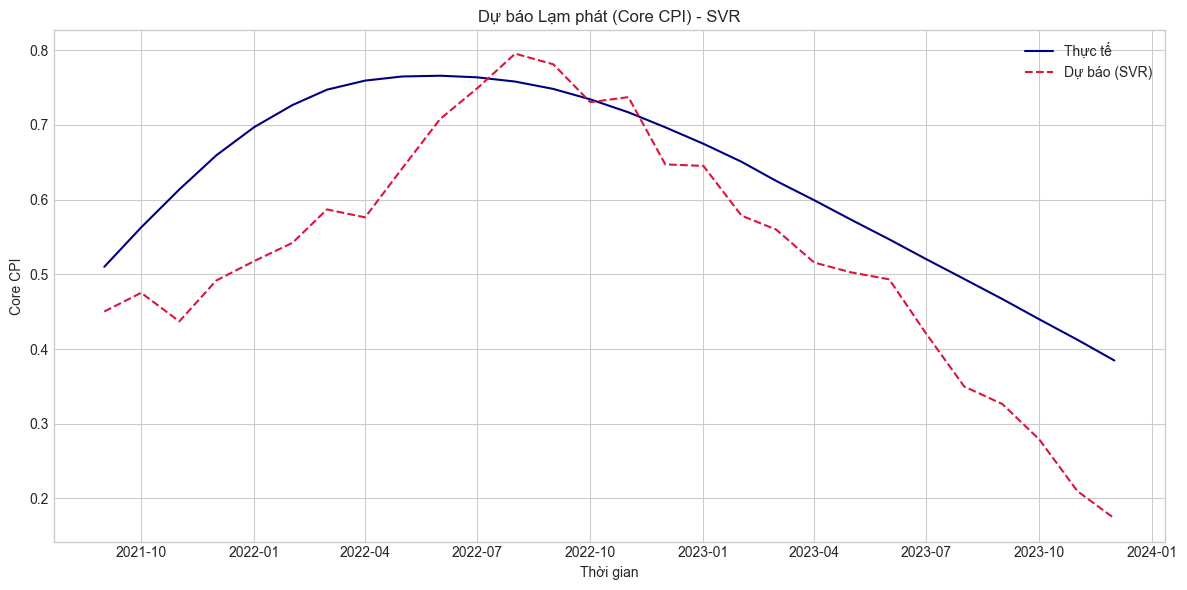

Đã lưu biểu đồ tại C:\HOCTAP\PTDLKD\DOAN\IS403.Q11\inflation-forecasting\results\figures\svr_forecast.png


In [9]:
# Evaluation
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_metrics = evaluate_model(y_train, y_train_pred, model_name="SVR - Train")
test_metrics = evaluate_model(y_test, y_test_pred, model_name="SVR - Test")

metrics_df = pd.DataFrame([
    {"Split": "Train", "RMSFE": train_metrics["RMSFE"], "MAPE": train_metrics["MAPE"]},
    {"Split": "Test", "RMSFE": test_metrics["RMSFE"], "MAPE": test_metrics["MAPE"]},
])

metrics_df

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Thực tế", color="navy")
plt.plot(y_test.index, y_test_pred, label="Dự báo (SVR)", color="crimson", linestyle="--")
plt.title("Dự báo Lạm phát (Core CPI) - SVR")
plt.xlabel("Thời gian")
plt.ylabel("Core CPI")
plt.legend()
plt.tight_layout()

forecast_fig_path = FIGURES_DIR / "svr_forecast.png"
plt.savefig(forecast_fig_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Đã lưu biểu đồ tại {forecast_fig_path}")

In [10]:
# Save results
predictions_df = pd.DataFrame(
    {
        "Actual": y_test,
        "Predicted_SVR": y_test_pred
    },
    index=y_test.index
)

pred_path = TABLES_DIR / "svr_predictions.csv"
metrics_path = TABLES_DIR / "svr_metrics.csv"
best_params_path = TABLES_DIR / "svr_best_params.txt"
grid_search_path = TABLES_DIR / "svr_grid_search.csv"

predictions_df.to_csv(pred_path)
metrics_df.to_csv(metrics_path, index=False)

with open(best_params_path, "w", encoding="utf-8") as f:
    f.write(str(svr_grid.best_params_))

cv_results_df = pd.DataFrame(svr_grid.cv_results_)
cv_results_df.to_csv(grid_search_path, index=False)

print(f"Đã lưu dự báo tại {pred_path}")
print(f"Đã lưu chỉ số đánh giá tại {metrics_path}")
print(f"Đã lưu tham số tốt nhất tại {best_params_path}")
print(f"Đã lưu kết quả Grid Search tại {grid_search_path}")

Đã lưu dự báo tại C:\HOCTAP\PTDLKD\DOAN\IS403.Q11\inflation-forecasting\results\tables\svr_predictions.csv
Đã lưu chỉ số đánh giá tại C:\HOCTAP\PTDLKD\DOAN\IS403.Q11\inflation-forecasting\results\tables\svr_metrics.csv
Đã lưu tham số tốt nhất tại C:\HOCTAP\PTDLKD\DOAN\IS403.Q11\inflation-forecasting\results\tables\svr_best_params.txt
Đã lưu kết quả Grid Search tại C:\HOCTAP\PTDLKD\DOAN\IS403.Q11\inflation-forecasting\results\tables\svr_grid_search.csv
